In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [3]:
teast.Print()

******************************************************************************
*Tree    :eastTree  : eastTree                                               *
*Entries :   270321 : Total =        64189330 bytes  File  Size =   22461437 *
*        :          : Tree compression factor =   2.86                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   270321 : Total  Size=    1084891 bytes  File Size  =       9161 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 118.32     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   270321 : Total  Size=    1085005 bytes  File Size  =       9229 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 117.46     *
*...................................................

In [4]:
twest.Print()

******************************************************************************
*Tree    :eventTree : eventTree                                              *
*Entries :   364619 : Total =        44823592 bytes  File  Size =   14560502 *
*        :          : Tree compression factor =   3.08                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   364619 : Total  Size=    1463293 bytes  File Size  =      12419 *
*Baskets :       46 : Basket Size=      32000 bytes  Compression= 117.73     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   364619 : Total  Size=    1463443 bytes  File Size  =      12512 *
*Baskets :       46 : Basket Size=      32000 bytes  Compression= 116.86     *
*...................................................

In [5]:
def constructUniqueID( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fill).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandEast).zfill(5)) 
    return uniqueID
def constructUniqueIDwest( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.eventNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandWest).zfill(5)) 
    return uniqueID
def constructUniqueIDeast( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillIndex).zfill(5) +
                            str(entry.calorimeterIndex).zfill(5) + str(entry.islandIndex).zfill(5)) 
    return uniqueID
def constructUniqueIDwave( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandNum).zfill(5)) 
    return uniqueID


def constructConditionFromUniqueIDWest( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && eventNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandWest == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDWave( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandNum == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDEast( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillIndex == "+str(int(uniqueID[10:15]))+
                 " && calorimeterIndex == "+str(int(uniqueID[15:20]))+
                 " && islandIndex == "+str(int(uniqueID[20:25]))
                )
    
    return condition

In [6]:
def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

In [7]:
def toMap( crystalsInCluster ):
    xtalMapEast = []
    for i in range(54):
        if(i in crystalsInCluster):
            xtalMapEast.append(1)
        else:
            xtalMapEast.append(0)

    xtalMapEast.reverse()
    list1 = []
    list2 = []
    xtal = []
    list2xtal = []
    for crystal in range(54):
        list2.append(xtalMapEast[crystal]) 
        list2xtal.append(crystal)
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal.reverse()
            xtal.append(list2xtal)
            list2xtal = []
    xtal.reverse()
    
    return( list1 )

def arrangeXtals( vec1 ):
    vec1.reverse()
    list1 = []
    list2 = []
    for crystal in range(54):
        list2.append(vec1[crystal]) 
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal = []
    return(list1)

def imshowCompare(vec1, vec2, showPlot = True, titleString = ''):
    vec3 = []
    for i in range(len(vec1)):
        vec3i = []
        for j in range(len(vec1[0])):
            if(vec1[i][j] > 0.1 and vec2[i][j] > 0.1):
                vec3i.append(2) #both recons include this xtal
            elif (vec1[i][j] > 0.1):
                vec3i.append(1) #only recon east includes this crystal
            elif (vec2[i][j] > 0.1):
                vec3i.append(3) #only recon west
            else:
                vec3i.append(5) #not inluded in either recon's cluster.
        vec3.append(vec3i)
        
    fig, ax = plt.subplots()

    cmap = matplotlib.colors.ListedColormap(['blue', 'xkcd:teal green', 'xkcd:forest green', 'xkcd:light grey'])
    cmap.set_over('xkcd:light grey')
    cmap.set_under('xkcd:light grey')
    
    bounds = [1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    cax = ax.imshow(vec3, interpolation='nearest', cmap=cmap, vmin=1,vmax=5)
    ax.set_title('Crystals Identified as Part of Cluster(s) in \n Island '+str(titleString))
    cbar = fig.colorbar(cax,
                        cmap=cmap,
                        boundaries = [0] + bounds + [5],
                        extend='both',
                        extendfrac='auto',
                        spacing='uniform',
                        ticks=[x + 0.5 for x in bounds],
                        orientation='vertical')
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    cbar.ax.set_yticklabels(['East Only', 'Both', 'West Only'])
          
    if(showPlot):
        plt.show()
    else:
        plt.close()
    
    return(vec3)

In [8]:
def islandPlot(uniqueIDref, saveImage = True):
    counter = 0
    
    fout = r.TFile("temp_tree_storage.root","recreate")
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(uniqueIDref) )
    
    crystalsEast = []
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if uniqueIDref == dong:
            crystalsEast += [x for x in entry3.crystalsEast]
                
    mapEast = toMap(crystalsEast)
    print("East: ", mapEast)
    
    crystalsWest = []
    
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(uniqueIDref) )
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (uniqueIDref == dong):
            crystalsWest += [x for x in entry2.crystalsWest]

    mapWest = toMap(crystalsWest)
    print("West: ", mapWest)


    twave_partial = twave.CopyTree( constructConditionFromUniqueIDWave(uniqueIDref) )
    for i,entry in enumerate(twave_partial):
        if( constructUniqueIDwave(entry) == uniqueIDref ):
            if counter > 3:
                break
            counter = counter + 1

            fig, axarr = plt.subplots(6,9, sharey=True, sharex=True,figsize=(15, 10))
            print("Entry #", i+1)
            plotVec = []
            for crystal in range(0,54):
                branchString = "twave.xtal"+str(crystal)
                entryVeci = []
                rootVec = eval(branchString)# t.xtal53
                length = rootVec.size()
                for ding in range(length):
                    entryVeci.append( rootVec[ding] )
                plotVec.append(entryVeci)

            plotVec.reverse()
            list1 = []
            list2 = []
            xtal = []
            list2xtal = []
            for crystal in range(54):
                list2.append(plotVec[crystal]) 
                list2xtal.append(crystal)
                if (crystal+1) % 9 == 0: #split into 9 column blocks
                    list1.append(list2)
                    list2 = []
                    list2xtal.reverse()
                    xtal.append(list2xtal)
                    list2xtal = []
            xtal.reverse()


            aboveThresholdVec = []
            for ding in range(9):
                for j in range(6):
                    if(len(list1[j][ding]) < 1):
                        axarr[j,ding].plot(list1[j][ding],color='g') 
                    elif(np.abs( np.mean((list1[j][ding])[0:6]) - np.max(list1[j][ding]) ) > 60): #global threshold = 60
                        axarr[j,ding].plot(list1[j][ding],color='r') 
                        aboveThresholdVec.append( (j, ding) )
                    else:
                        axarr[j,ding].plot(list1[j][ding],color='black') 
                    axarr[j,ding].set_title(str(xtal[j][ding]),y = 0.95)


            #grey out all of the +3x3 grid
            xtalsVec = []
            for xtal in aboveThresholdVec:
                for nxtals in ReturnNeighbors_4(xtal[1],xtal[0]):
                    axarr[nxtals[1],nxtals[0]].set_facecolor('xkcd:light grey')
                    xtalsVec.append(nxtals)
                xtalsVec.append((xtal[1],xtal[0]))

            plt.suptitle("Unpacked Islands from Calo "+str(twave.caloNum)
                         +" [run "+str(twave.runNum)+", subRun "+str(twave.subRunNum)
                         +", fill "+str(twave.fillNum)+", island "+str(twave.islandNum)+"]"
                         ,y = 0.93, fontsize=20)
            

            #now lets color them ala the plots above
            for ding in range(9):
                for j in range(6):
                    in3x3check = False
                    if((mapWest[j][ding] == 1) and (mapEast[j][ding] == 1)):
                        axarr[j,ding].set_facecolor('xkcd:teal green')
                        in3x3check = True
                    elif(mapWest[j][ding] == 1):
                        axarr[j,ding].set_facecolor('xkcd:forest green')
                        in3x3check = True
                    elif(mapEast[j][ding] == 1):
                        axarr[j,ding].set_facecolor('xkcd:cerulean')
                        in3x3check = True
                      
                    #make the borders red if this xtal is not within the 3x3 grid that would be saved
                    if( (ding,j) not in xtalsVec and in3x3check):
                        #axarr[j,ding].set_facecolor('xkcd:lilac')
                        axarr[j,ding].spines['right'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['left'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['top'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['bottom'].set_color('xkcd:neon purple')
                        axarr[j,ding].title.set_color('xkcd:neon purple')
                        axarr[j,ding].spines['right'].set_linewidth(3)
                        axarr[j,ding].spines['left'].set_linewidth(3)
                        axarr[j,ding].spines['top'].set_linewidth(3)
                        axarr[j,ding].spines['bottom'].set_linewidth(3)
                        
            #create custom lines for the legend with the same colors as above
            from matplotlib.lines import Line2D
            custom_lines = [Line2D([0], [0], color='xkcd:forest green', lw=4),
                            Line2D([0], [0], color='xkcd:teal green', lw=4),
                            Line2D([0], [0], color='xkcd:cerulean', lw=4),
                            Line2D([0], [0], color='xkcd:light grey', lw=4),
                            Line2D([0], [0], color='r', lw=4),
                            Line2D([0], [0], color='xkcd:neon purple', lw=4)]

            fig.legend(custom_lines,
                       ('Recon West Only', 'Shared', 'Recon East Only', 
                        'in 3x3 Grid', 'Above Threshold', 'In a Cluster, but\n not in 3x3 Grid'),
                       'upper right')

            if(saveImage):
                plt.savefig("./images/UnpackedIslands_calo"+str(twave.caloNum).zfill(2)+"_run"+str(twave.runNum)+"_subRun"
                            +str(twave.subRunNum).zfill(5)+"_uniqueID_"+str(uniqueIDref)+".png",bbox_inches='tight')
            plt.show()

            break

In [51]:
def islandPlotGreyscale(uniqueIDref, saveImage = True):
    counter = 0
    
    fout = r.TFile("temp_tree_storage.root","recreate")
    
    '''
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(uniqueIDref) )
    
    crystalsEast = []
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if uniqueIDref == dong:
            crystalsEast += [x for x in entry3.crystalsEast]
                
    mapEast = toMap(crystalsEast)
    print("East: ", mapEast)
    
    crystalsWest = []
    
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(uniqueIDref) )
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (uniqueIDref == dong):
            crystalsWest += [x for x in entry2.crystalsWest]

    mapWest = toMap(crystalsWest)
    print("West: ", mapWest)
    '''
    twave_partial = twave.CopyTree( constructConditionFromUniqueIDWave(uniqueIDref) )
    for i,entry in enumerate(twave_partial):
        if( constructUniqueIDwave(entry) == uniqueIDref ):
            if counter > 3:
                break
            counter = counter + 1

            print("Entry #", i+1)
            plotVec = []
            for crystal in range(0,54):
                branchString = "twave.xtal"+str(crystal)
                entryVeci = []
                rootVec = eval(branchString)# t.xtal53
                length = rootVec.size()
                for ding in range(length):
                    entryVeci.append( rootVec[ding] )
                    
                #greyscale value  = max above pedestal - min below pedestal
                greyscalevalue = (np.amax(entryVeci) - np.amin(entryVeci)) - np.std(entryVeci)
                    
                plotVec.append(greyscalevalue)

            plotVec.reverse()
            list1 = []
            list2 = []
            xtal = []
            list2xtal = []
            for crystal in range(54):
                list2.append(plotVec[crystal]) 
                list2xtal.append(crystal)
                if (crystal+1) % 9 == 0: #split into 9 column blocks
                    list1.append(list2)
                    list2 = []
                    list2xtal.reverse()
                    xtal.append(list2xtal)
                    list2xtal = []
            xtal.reverse()

            print(list1)
            plt.imshow(list1, cmap=matplotlib.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=1))
            plt.title(str(uniqueIDref))
            plt.colorbar()
            plt.show()

            break

In [52]:
vecX = []

for i, entry in enumerate(tcomp):
    if i > 4:
        break
    print(constructUniqueID(entry))
    vecX.append( constructUniqueID(entry) )

1636400282000020000100108
1636400282000020000100104
1636400282000020000100107
1636400282000020000100109
1636400282000020000100111


*************************************************************
Entry # 1
[[15.327884932937973, 10.249567498989393, 22.539847988333335, 10.171835388772129, 12.632641933797245, 9.222650936581935, 14.36179174911834, 7.654423289720366, 15.617263448863559], [11.857115158529194, 19.177287639016132, 12.477948851782894, 19.115221088488518, 20.136022519616553, 8.101933588177172, 6.404922146496575, 20.326273140995575, 15.380573591232267], [39.40241425939796, 1096.5860372838376, 14.85047896202153, 15.804414084246327, 8.247838219931863, 19.752080656160352, 6.900403729697089, 8.37971052075972, 8.099099292720481], [42.54982247454981, 86.34334017633711, 29.974737120152547, 15.911849711692728, 17.176809969813114, 11.483725430059383, 11.205540371089379, 17.893860131188962, 16.953753773984594], [21.224241765383063, 11.589249643688419, 11.965595205522604, 10.87224170174255, 10.969836909891615, 13.571955433116894, 13.404539578838559, 11.396728706599955, 12.042068101458185], [10.892765265701295, 13.67817160

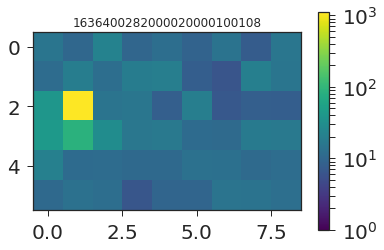

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


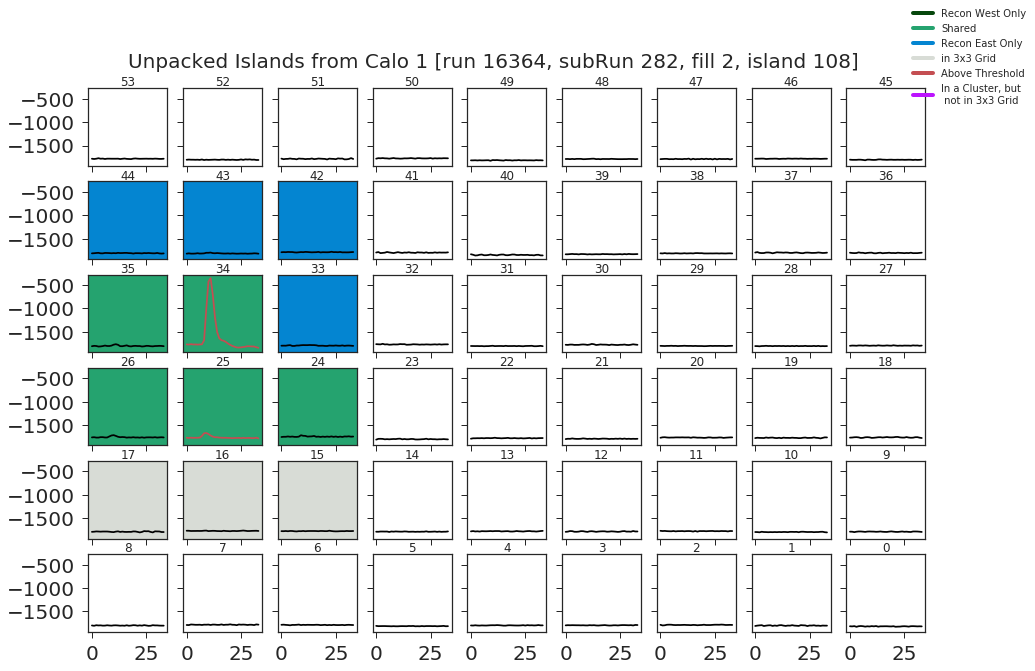

*************************************************************
Entry # 1
[[15.746765936372652, 9.948406609290448, 15.411917442747768, 9.91311015925594, 12.333181821312166, 8.16745108897775, 12.609479909319779, 8.684832619441956, 12.341793382761033], [204.28041850327423, 11.399396174896653, 10.628716037537693, 11.73112036556038, 22.406316153570398, 9.52245297180134, 5.85006460045372, 9.084714612788503, 13.197077147479556], [28.18256933371186, 9.267857332725757, 14.055383415336795, 6.702900379463993, 8.078813026639114, 15.382171237924744, 9.034269810728636, 8.870214774851865, 8.215120190105944], [12.325601642991902, 10.727046865257275, 16.813586124412275, 12.144190192265672, 10.580935800544248, 17.524701936068787, 7.994634427857033, 25.027826171265733, 14.219832638913152], [18.870925391581892, 7.542158669535765, 10.944040430750288, 9.36238784059897, 11.767322885506672, 11.270090856036541, 10.823523965146281, 8.963005872028507, 7.186540287198774], [13.840806702148974, 9.481161807894226, 7.

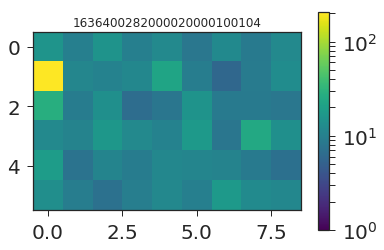

East:  [[1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


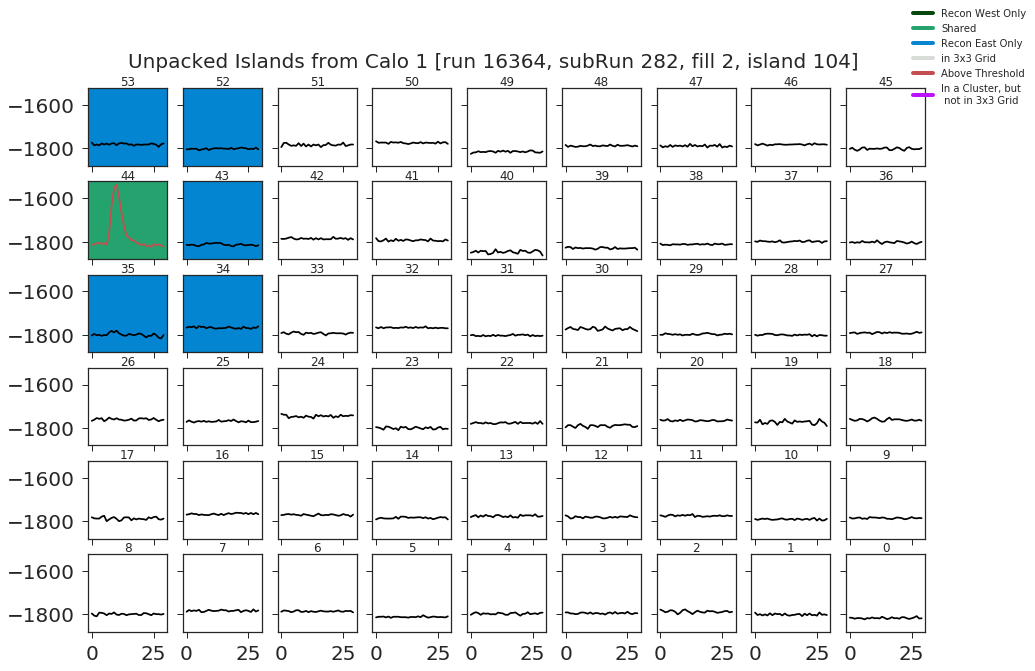

*************************************************************
Entry # 1
[[7.475919463883782, 11.497934493771233, 12.308801199142763, 10.849067652956132, 11.973914259335181, 6.139384068726212, 17.018307160759882, 8.098178273969912, 11.950063602403361], [14.238272088804187, 10.576696293861321, 12.58152805873397, 14.28147662823237, 14.535056456704996, 10.511332790581534, 6.573864375606291, 10.495313383078555, 9.66116157070562], [15.529096208119274, 23.22268137259765, 27.369242716796194, 10.106734966719998, 7.8446992433345155, 12.568084694148938, 9.397465387444377, 5.983083479721971, 9.397465387444377], [13.291802276508616, 685.0706646463082, 123.45874782228165, 14.582196466292032, 12.700168354462779, 11.607419227809192, 12.359598201774253, 13.609719391654064, 12.259730376179036], [19.564511404500145, 34.679515675404815, 22.483509651304125, 10.799334320845844, 11.331705845786553, 12.315968990198998, 10.424499238806318, 10.21080400024149, 7.4802889083651625], [17.200436199801455, 14.7781886

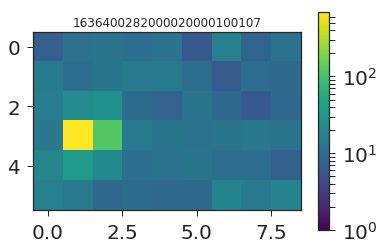

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


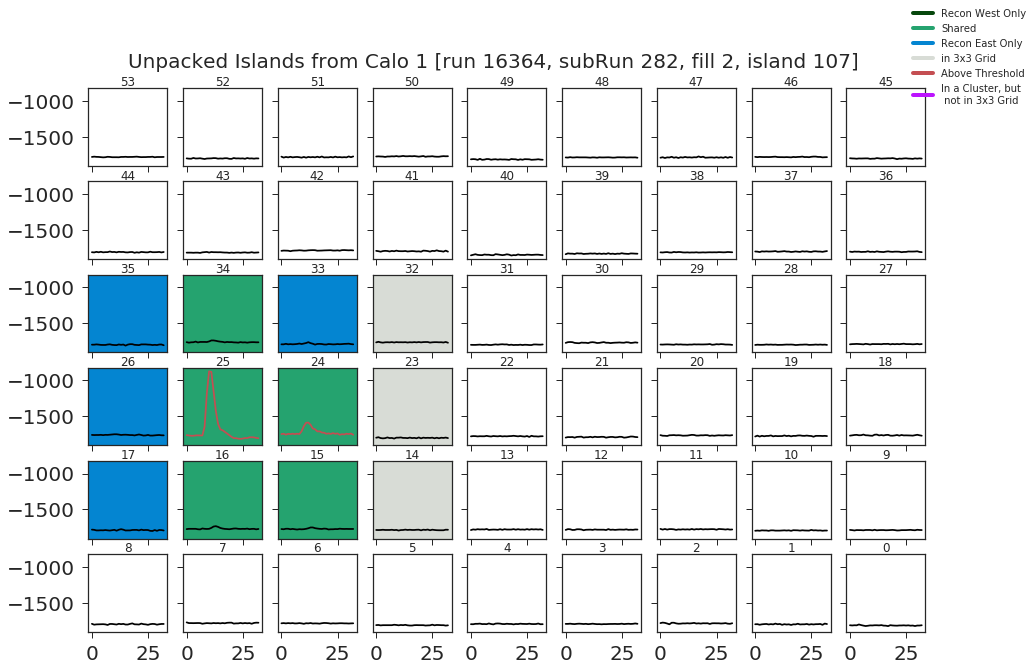

*************************************************************
Entry # 1
[[12.94616308295462, 15.755304018582201, 17.962736512996365, 8.313408583818521, 12.973840423244503, 9.217696828614825, 10.787388725505284, 12.30469882248755, 9.015829522714897], [10.691777525996777, 11.791277756255615, 9.755413161895648, 13.79911188705293, 26.59822377410586, 13.421090424444898, 5.181045973643094, 8.331462244973851, 11.374057234662963], [17.74632920298006, 11.660487498151863, 10.117069606920566, 8.524780807272727, 9.032895192700467, 17.233990794175906, 8.950922270587384, 8.627894759945947, 9.172263493534096], [13.940722505941817, 10.08102074035853, 16.966130340384247, 11.375086806225362, 10.666927093506654, 12.548876546308787, 8.695961426104155, 11.526226599670029, 687.2849783019744], [13.088676985780715, 9.414002928054737, 8.79112558675164, 12.252083912358763, 19.846212709327247, 20.372182897447004, 16.65726180848995, 10.75496172017956, 145.74585094224574], [10.731771627771073, 12.233370206670159, 

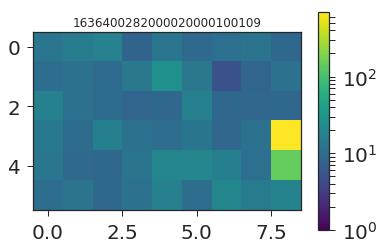

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


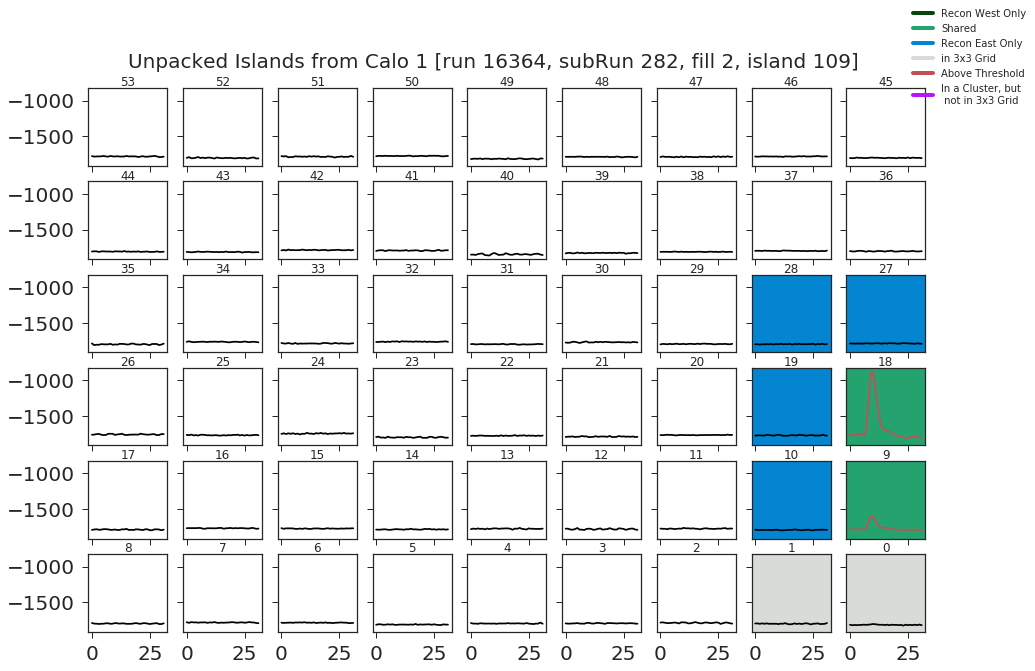

*************************************************************
Entry # 1
[[13.688868062114246, 12.521503269396764, 19.305430294295512, 12.250252533755631, 16.71450435644517, 8.449139938698792, 10.075482820255809, 11.012422413608185, 15.595936428566173], [13.200244879218587, 7.337813681139709, 9.227546559773376, 11.083516503902178, 31.883206228191426, 10.344494824242371, 6.856395250445164, 12.259730376179036, 10.885709351351291], [22.08519640744586, 12.46712929896008, 13.07297980609906, 17.17945123903357, 371.8704869111797, 153.38186763729817, 22.004899459835137, 8.111499637626068, 10.348181835495858], [12.33395948246385, 12.577833612859468, 16.544781186343958, 17.54894104691628, 437.0899992270655, 158.8633930402362, 28.74800936102839, 24.915957740872145, 19.05952390810744], [16.633026205253223, 19.647918137704174, 13.800932484540805, 14.371220029109647, 15.2176863950617, 29.436709614664473, 13.075786825895836, 9.947355088615023, 6.488319298775503], [11.083282047109122, 13.63741595180171

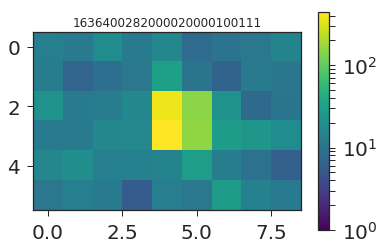

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1


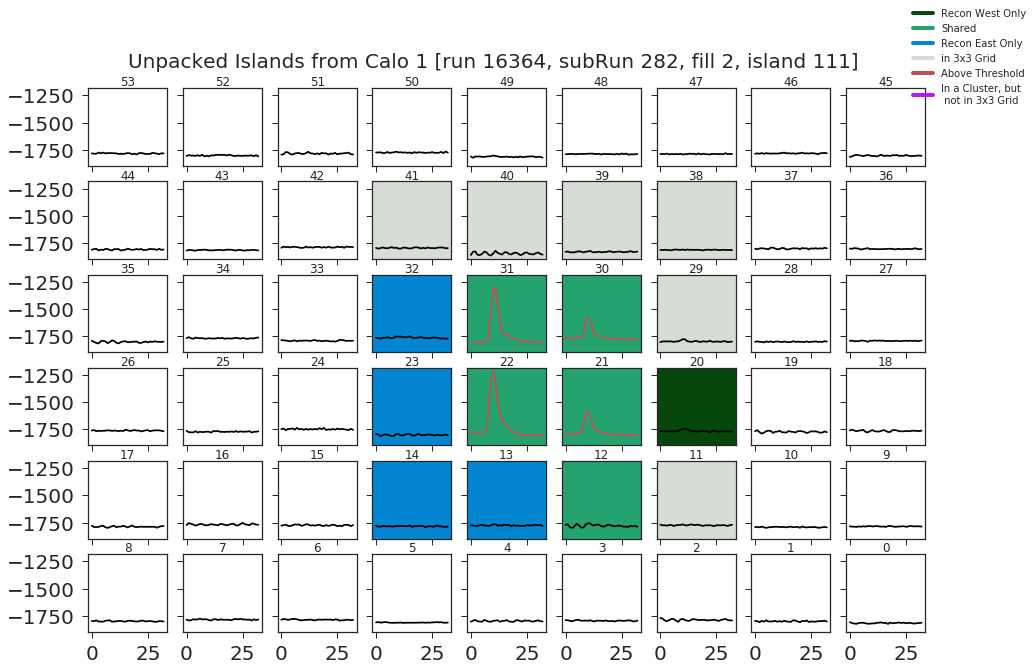

In [53]:
uniqueIDref = 1636400282000020001100093
#islandPlot(uniqueIDref, saveImage = True)

for idnum in vecX:
    print("*************************************************************")
    islandPlotGreyscale(idnum, saveImage = True)
    islandPlot(idnum, saveImage = True)